In [1]:
import os
import gensim
import keras
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

np.random.seed(1003)

In [2]:
print(gensim.__version__)
print(keras.__version__)

3.6.0
2.8.0


In [3]:
# This code is to download GoogleNews word vectors if you don't have it

# ! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# ! gzip -d GoogleNews-vectors-negative300.bin.gz


## Specify Hyperparameters


In [4]:
# Specify the folder locations

DATA_DIR = 'drive/MyDrive/Tutorial/week 7/'
# You can download the GoogleNews Vectors from https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
W2V_DIR = 'drive/MyDrive/Tutorial/week 7/GoogleNews-vectors-negative300.bin'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 30
MAX_VOCAB_SIZE = 20000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 32
N_EPOCHS = 10


## Load Data

In [5]:
# Read the text files of positive and negative sentences
with open(DATA_DIR+'rt-polarity.neg', 'r', errors='ignore') as f:
    neg = f.readlines()
    
with open(DATA_DIR+'rt-polarity.pos', 'r', errors='ignore') as f:
    pos = f.readlines()

In [6]:
print('Number of negative sentences:', len(neg))
print('Number of positive sentences:', len(pos))

Number of negative sentences: 5331
Number of positive sentences: 5331


In [7]:
# Create a dataframe to store the sentence and polarity as 2 columns
df = pd.DataFrame(columns=['sentence', 'polarity'])
df['sentence'] = neg + pos
df['polarity'] = [0]*len(neg) + [1]*len(pos)
df = df.sample(frac=1, random_state=10) # Shuffle the rows
df.reset_index(inplace=True, drop=True)

In [8]:
df

,sentence,polarity
0,"funny , somber , absurd , and , finally , achi...",1
1,"moore's complex and important film is also , b...",1
2,[scherfig] has made a movie that will leave yo...,1
3,the powerful success of read my lips with such...,1
4,the film is filled with humorous observations ...,1
...,...,...
10657,this is one of the outstanding thrillers of re...,1
10658,beautifully produced . \n,1
10659,life or something like it has its share of hig...,0
10660,even if you don't understand what on earth is ...,1


## Pre-processing 

In [9]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq = [text_to_word_sequence(sent) for sent in df['sentence']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

90th Percentile Sentence Length: 31.0
Number of words in vocabulary: 19180


In [10]:
word_seq[0]

['funny',
 'somber',
 'absurd',
 'and',
 'finally',
 'achingly',
 'sad',
 'bartleby',
 'is',
 'a',
 'fine',
 'understated',
 'piece',
 'of',
 'filmmaking']

In [11]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'and': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'in': 7,
 'that': 8,
 'it': 9,
 'as': 10,
 'but': 11,
 'with': 12,
 'film': 13,
 'this': 14,
 'for': 15,
 'its': 16,
 'an': 17,
 'movie': 18,
 "it's": 19,
 'be': 20,
 'on': 21,
 'you': 22,
 'not': 23,
 'by': 24,
 'one': 25,
 'about': 26,
 'like': 27,
 'more': 28,
 'has': 29,
 'are': 30,
 'at': 31,
 'than': 32,
 'from': 33,
 'all': 34,
 'have': 35,
 'his': 36,
 'so': 37,
 'if': 38,
 'or': 39,
 'too': 40,
 'story': 41,
 'i': 42,
 'out': 43,
 'just': 44,
 'up': 45,
 'who': 46,
 'what': 47,
 'into': 48,
 'good': 49,
 'no': 50,
 'most': 51,
 'even': 52,
 'comedy': 53,
 'much': 54,
 'will': 55,
 'time': 56,
 'some': 57,
 'can': 58,
 'well': 59,
 'only': 60,
 'characters': 61,
 'little': 62,
 'funny': 63,
 'way': 64,
 'director': 65,
 'their': 66,
 'make': 67,
 'been': 68,
 'enough': 69,
 'very': 70,
 'when': 71,
 'your': 72,
 'never': 73,
 'makes': 74,
 'may': 75,
 'there': 76,
 'bad': 77,
 'life': 78,
 'best': 79,
 'which': 80,
 

In [12]:
# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = df['polarity']

In [13]:
X

array([[  63, 1961, 1962, ...,    0,    0,    0],
       [2126,  524,    3, ...,    0,    0,    0],
       [4503,   29,   87, ...,    0,    0,    0],
       ...,
       [  78,   39,  101, ...,    0,    0,    0],
       [  52,   38,   22, ..., 3687,    4,   46],
       [  12, 3630,   62, ...,    0,    0,    0]], dtype=int32)

In [14]:
y

0        1
1        1
2        1
3        1
4        1
        ..
10657    1
10658    1
10659    0
10660    1
10661    0
Name: polarity, Length: 10662, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.1)

In [16]:
X_train.shape

(9595, 30)

## Loading the word vectors into gensim

In [55]:
%%time
# You can download the GoogleNews Vectors from https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# Load the word2vec embeddings 
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True, limit=500000)

CPU times: user 6.11 s, sys: 754 ms, total: 6.86 s
Wall time: 7.11 s


In [56]:
print('Number of words in this pre-trained w2v model:', len(embeddings.vocab))
print('Dimension of w2v:', embeddings.vector_size)

Number of words in this pre-trained w2v model: 500000
Dimension of w2v: 300


In [57]:
%%time
embeddings.most_similar('cat')

CPU times: user 557 ms, sys: 16.1 ms, total: 573 ms
Wall time: 515 ms


[('cats', 0.8099379539489746),
 ('dog', 0.7609456777572632),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326233983039856),
 ('beagle', 0.7150583267211914),
 ('puppy', 0.7075453996658325),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931377410889),
 ('chihuahua', 0.6709762215614319)]

In [58]:
embeddings.doesnt_match('cat dog cow fish volunteer lion snake'.split(' '))

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'volunteer'

In [92]:
embeddings.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454),
 ('royal_palace', 0.5087165832519531)]

In [59]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector


# Keras Sequential API


In [60]:
# Build a sequential model by stacking neural net units 
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True))

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_embedding_layer (Embed  (None, None, 300)        5754300   
 ding)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 128)               219648    
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 5,974,077
Trainable params: 219,777
Non-trainable params: 5,754,300
_________________________________________________________________


In [62]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 19s 13ms/step - loss: 0.5206 - accuracy: 0.7449 - val_loss: 0.4964 - val_accuracy: 0.7395
Epoch 2/10
300/300 [==============================] - 3s 8ms/step - loss: 0.4533 - accuracy: 0.7851 - val_loss: 0.4588 - val_accuracy: 0.7694
Epoch 3/10
300/300 [==============================] - 2s 8ms/step - loss: 0.4305 - accuracy: 0.8014 - val_loss: 0.4634 - val_accuracy: 0.7704
Epoch 4/10
300/300 [==============================] - 2s 8ms/step - loss: 0.3959 - accuracy: 0.8174 - val_loss: 0.4813 - val_accuracy: 0.7648
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.3658 - accuracy: 0.8348 - val_loss: 0.4282 - val_accuracy: 0.7966
Epoch 6/10
300/300 [==============================] - 3s 8ms/step - loss: 0.3431 - accuracy: 0.8439 - val_loss: 0.4455 - val_accuracy: 0.8022
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.3091 - accuracy: 0.8624 - val_loss: 0.4711 - val_accuracy: 0.8041
Epoc

In [64]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 7ms/step - loss: 0.5303 - accuracy: 0.8004


In [65]:
print("Accuracy on Test Set = {0:4.3f}".format(acc))

Accuracy on Test Set = 0.800


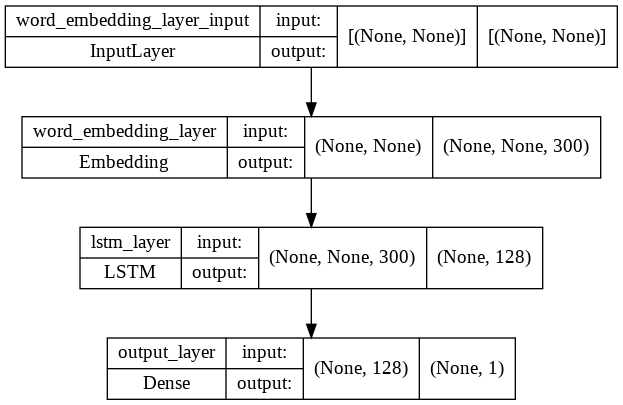

In [66]:
plot_model(model, to_file='basic_lstm_classifier.png', show_layer_names=True, show_shapes=True)
Image('basic_lstm_classifier.png')

## How to use the model?

In [69]:
model.predict(X_test[:5])

array([[0.00190416],
       [0.9962714 ],
       [0.9613344 ],
       [0.7510902 ],
       [0.06358649]], dtype=float32)

In [90]:
to_be_predicted = ["I love this great movie",
                   "This is garbage! I hate it so bad",
                   "Couldn't be worse than this! not worth watching",
                   "The best movie I've ever seen. Excellent! definitely recommend it"]

word_seq = [text_to_word_sequence(sent) for sent in to_be_predicted]
X_predict = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])
X_predict = pad_sequences(X_predict, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

print(X_predict)

[[  42   85   14  131   18    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  14    6 3405   42 1139    9   37   77    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1038   20  705   32   14   23  217  201    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1   79   18  702  150  196  642  730  948    9    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [91]:
model.predict(X_predict)

array([[0.9668615 ],
       [0.00624665],
       [0.01097183],
       [0.8935825 ]], dtype=float32)



## Modify the network by adding two more Dense layers with Batch-Normalization and Dropouts:


In [106]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

model.add(Dense(32, name='dense_1'))
model.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model.add(Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(Activation(activation='relu', name='activation_1'))

model.add(Dense(8, name='dense_2'))
model.add(BatchNormalization(name='bn_2'))
model.add(Dropout(rate=0.3, name='dropout_2'))
model.add(Activation(activation='relu', name='activation_2'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_embedding_layer (Embed  (None, None, 300)        5754300   
 ding)                                                           
                                                                 
 lstm_layer (LSTM)           (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 bn_1 (BatchNormalization)   (None, 32)                128       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                      

In [107]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [108]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 9s 18ms/step - loss: 0.5683 - accuracy: 0.7119 - val_loss: 0.4852 - val_accuracy: 0.7648
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4953 - accuracy: 0.7685 - val_loss: 0.4733 - val_accuracy: 0.7694
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4742 - accuracy: 0.7813 - val_loss: 0.5281 - val_accuracy: 0.7591
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4537 - accuracy: 0.7861 - val_loss: 0.4443 - val_accuracy: 0.7816
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4359 - accuracy: 0.8022 - val_loss: 0.4370 - val_accuracy: 0.7826
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4153 - accuracy: 0.8132 - val_loss: 0.4530 - val_accuracy: 0.7976
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.3911 - accuracy: 0.8237 - val_loss: 0.4572 - val_accuracy: 0.7901

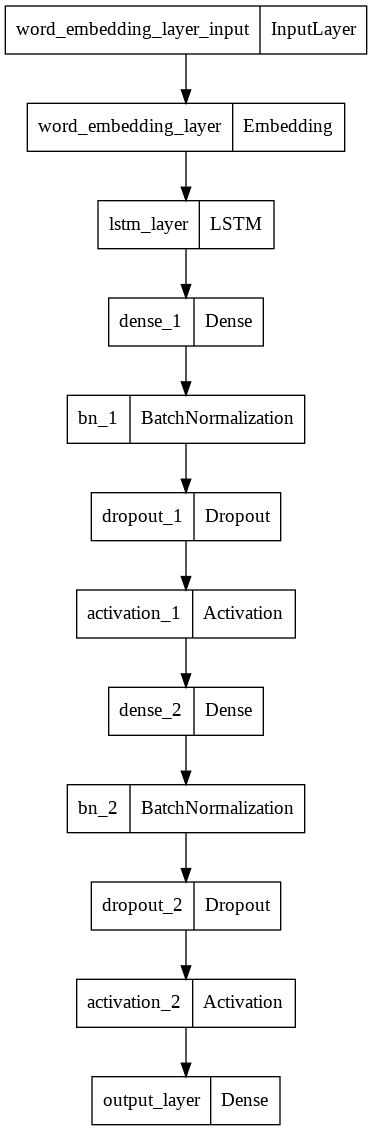

In [109]:
plot_model(model, to_file='modified_lstm_classifier.png', show_layer_names=True)
Image('modified_lstm_classifier.png')

In [110]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=BATCH_SIZE)

34/34 [==============================] - 0s 4ms/step - loss: 0.4862 - accuracy: 0.7779


In [111]:
print("Accuracy on Test Set = {0:4.3f}".format(acc))

Accuracy on Test Set = 0.778
